In [169]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate

In [170]:
# Goal: 60% train, 20% validate, 20% test -> 80% train+validate, 20% test

folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [171]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X = []
y = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))    
        if adc_t2 == 't2':
            if label == 'TRUE':
                X += 3 * [array]
                y += 3 * [1]
            else:
                X.append(array)
                y.append(0)

# Random over-sampling to remedy imbalanced dataset
print('Original: indolent={}, clinsig={}'.format(Counter(y)[0], Counter(y)[1]))

Original: indolent=193, clinsig=189


In [172]:
X, y = shuffle(X, y)

# Now split this into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=286, nval=96


In [173]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [174]:
chanDim = 3

model = tf.keras.Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.summary()

In [175]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=3e-4), metrics=['acc'])

Number of trainable weights before freezing the conv base: 292
Number of trainable weights after freezing the conv base: 80


In [176]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [177]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=120,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/120
4/4 [==============================] - 4s 924ms/step - loss: 0.6956 - acc: 0.5495 - val_loss: 0.6932 - val_acc: 0.4688
Epoch 2/120
4/4 [==============================] - 1s 248ms/step - loss: 0.6983 - acc: 0.4910 - val_loss: 0.6932 - val_acc: 0.4688
Epoch 3/120
4/4 [==============================] - 1s 270ms/step - loss: 0.6885 - acc: 0.5586 - val_loss: 0.6931 - val_acc: 0.5156
Epoch 4/120
4/4 [==============================] - 1s 239ms/step - loss: 0.6924 - acc: 0.5586 - val_loss: 0.6935 - val_acc: 0.4531
Epoch 5/120
4/4 [==============================] - 1s 248ms/step - loss: 0.6927 - acc: 0.5045 - val_loss: 0.6928 - val_acc: 0.5469
Epoch 6/120
4/4 [==============================] - 1s 201ms/step - loss: 0.6712 - acc: 0.5742 - val_loss: 0.6933 - val_acc: 0.4844
Epoch 7/120
4/4 [==============================] - 1s 202ms/step - loss: 0.6829 - acc: 0.5360 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/120
4/4 [==============================] - 1s 204ms/step - loss: 0.6866 - a

4/4 [==============================] - 1s 274ms/step - loss: 0.6804 - acc: 0.5541 - val_loss: 0.6972 - val_acc: 0.4844
Epoch 64/120
4/4 [==============================] - 1s 288ms/step - loss: 0.6747 - acc: 0.5312 - val_loss: 0.6993 - val_acc: 0.4688
Epoch 65/120
4/4 [==============================] - 1s 241ms/step - loss: 0.6853 - acc: 0.5450 - val_loss: 0.6912 - val_acc: 0.5312
Epoch 66/120
4/4 [==============================] - 1s 258ms/step - loss: 0.6863 - acc: 0.5225 - val_loss: 0.7017 - val_acc: 0.4531
Epoch 67/120
4/4 [==============================] - 1s 226ms/step - loss: 0.6803 - acc: 0.5586 - val_loss: 0.7020 - val_acc: 0.4531
Epoch 68/120
4/4 [==============================] - 1s 218ms/step - loss: 0.6783 - acc: 0.5766 - val_loss: 0.6956 - val_acc: 0.5000
Epoch 69/120
4/4 [==============================] - 1s 229ms/step - loss: 0.6587 - acc: 0.6441 - val_loss: 0.7046 - val_acc: 0.4375
Epoch 70/120
4/4 [==============================] - 1s 202ms/step - loss: 0.6773 - acc: 0

In [178]:
model.save_weights('models/model_t2_weights.h5')
model.save('models/model_t2_keras.h5')

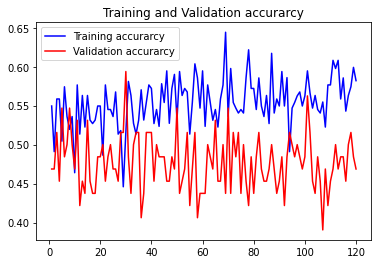

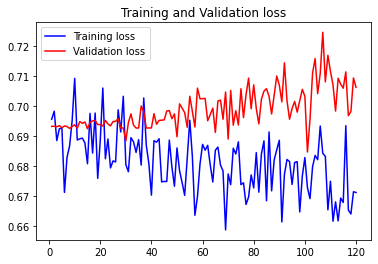

In [179]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

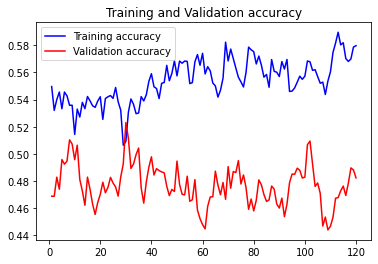

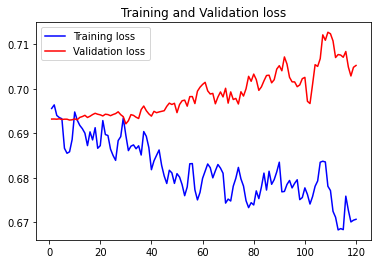

In [180]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accuracy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [181]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 't2':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 't2':
            X_test.append(array)

In [182]:
x = np.array(X_test)
y = np.array(y_test)
total = len(x)
test_datagen = ImageDataGenerator(rescale=1./255)

predictions = 0
correct = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    prediction = 1 if pred > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    if prediction == actual:
        correct += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    predictions += prediction
    i += 1
    if i == total:
        break
    
print('ACCURACY: {}%'.format(correct/total * 100))
print('FALSE POSITIVE: {}%'.format(false_pos/(total-correct) * 100))
print('FALSE NEGATIVE: {}%'.format(false_neg/(total-correct) * 100))
print('CLINICALLY SIGNIFICANT PREDICTION: {}%'.format(predictions/total * 100))

ACCURACY: 17.741935483870968%
FALSE POSITIVE: 100.0%
FALSE NEGATIVE: 0.0%
CLINICALLY SIGNIFICANT PREDICTION: 100.0%
